# Import

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/kaggle/src")

import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import polars as pl
import seaborn as sns
from sklearn.metrics import confusion_matrix

from common.constant import TRAIN_CSV_PATH

# Data

In [5]:
trn_df = pl.read_csv(TRAIN_CSV_PATH)
trn_df.head()

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


# Single model evaluation

## exp001

In [7]:
oof_preds_001 = pl.read_csv("/kaggle/temp/exp001_lgb_baseline/oof_prediction.csv")
oof_preds_001 = (
    oof_preds_001
    .select(pl.col("id"), pl.col("sii").alias("preds"))
    .join(trn_df, on="id", how="left")
    .select("id", "sii", "preds", pl.exclude("id", "sii", "preds"))
)
oof_preds_001

id,sii,preds,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,…,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,i64,i64,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,…,i64,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64
"""00008ff9""",2,0,"""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,…,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3
"""000fd460""",0,0,"""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,…,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0
"""00105258""",0,0,"""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,…,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2
"""00115b9f""",1,0,"""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,…,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0
"""001f3379""",1,1,"""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,null,60,73,102,null,null,null,null,"""Summer""",12,0,16.5,2,17.9,2,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,…,2,32.9141,20.902,79.6982,35.3804,63.1265,null,null,"""Spring""",4.11,"""Summer""",3,3,3,0,2,1,0,2,2,1,0,1,3,3,2,1,3,1,2,1,34,"""Summer""",40,56,"""Spring""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""",0,0,"""Fall""",8,0,null,null,"""Fall""",17.13981,52.5,67.2,25.0,60,65,112,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,8.0,1,10.0,1,12.0,1,"""Fall""",3,…,1,25.7118,15.815,49.3301,20.2645,36.7181,null,null,"""Fall""",3.44,"""Fall""",3,3,3,0,0,0,0,3,0,0,0,0,2,0,0,3,0,2,2,1,22,"""Fall""",41,58,"""Fall""",2
"""ff759544""",1,0,"""Summer""",7,1,null,null,"""Summer""",13.927006,48.5,46.6,23.0,65,75,105,null,null,null,null,"""Summer""",0,0,null,null,null,null,0,0,9.0,0,8.5,0,4.5,0,"""Fall""",1,…,1,20.0572,15.14,42.8185,18.0937,30.0453,null,null,null,null,"""Summer""",1,3,3,0,3,0,0,0,0,0,3,0,5,1,0,5,3,3,3,0,33,"""Summer""",48,67,"

In [8]:
booster = lgb.Booster(model_file="/kaggle/temp/exp001_lgb_baseline/booster.0.txt")

### Confusion matrix

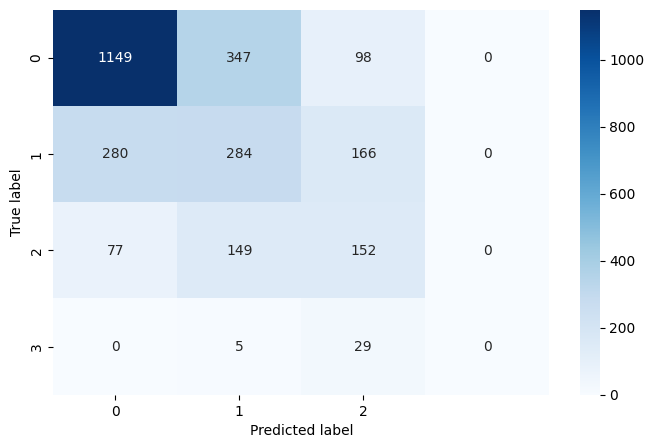

In [9]:
cm = confusion_matrix(oof_preds_001["sii"], oof_preds_001["preds"])
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", 
    xticklabels=oof_preds_001["preds"].unique(), 
    yticklabels=oof_preds_001["sii"].unique()
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Feature importance

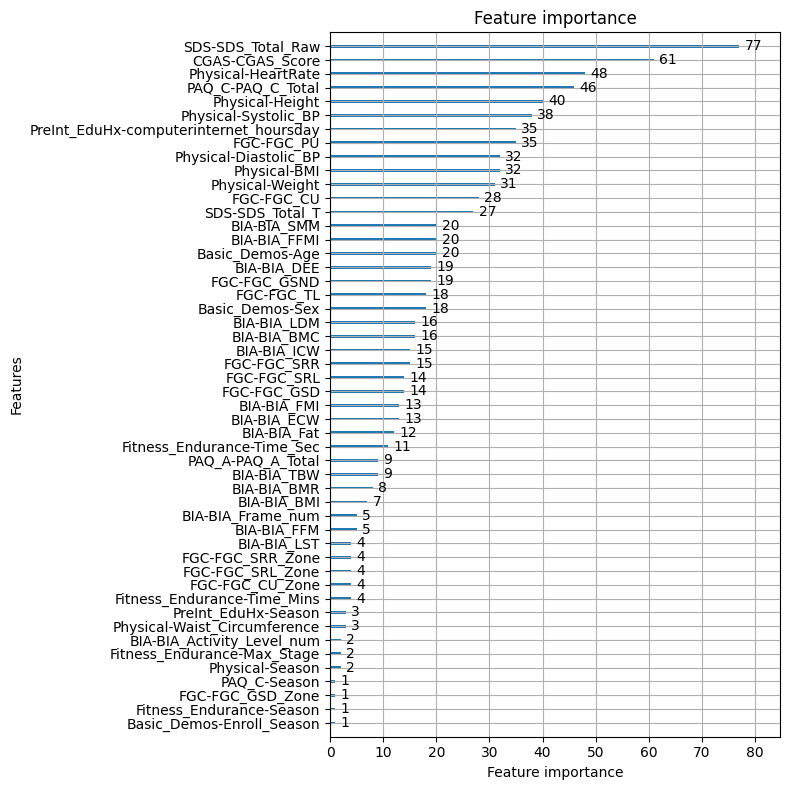

In [10]:
lgb.plot_importance(booster, figsize=(8, 8))
plt.tight_layout()
plt.show()

### Learning curve

In [11]:
eval_result = pl.read_csv("/kaggle/temp/exp001_lgb_baseline/log_metric.csv")

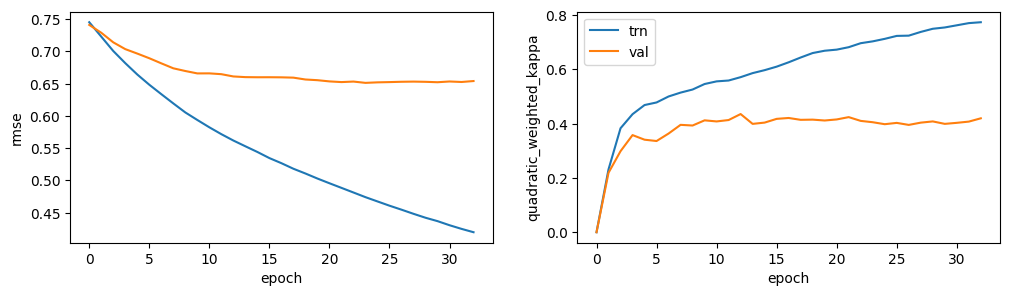

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(eval_result["trn_rmse"].to_numpy(), label="trn")
axes[0].plot(eval_result["val_rmse"].to_numpy(), label="val")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("rmse")
axes[1].plot(eval_result["trn_qwk"].to_numpy(), label="trn")
axes[1].plot(eval_result["val_qwk"].to_numpy(), label="val")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("quadratic_weighted_kappa")
plt.legend()
plt.show()

## exp006

In [6]:
oof_preds_006 = pl.read_csv("/kaggle/temp/exp006_hyperparameter_tuning/oof_prediction.csv")
oof_preds_006 = (
    oof_preds_006
    .select(pl.col("id"), pl.col("sii").alias("preds"))
    .join(trn_df, on="id", how="left")
    .select("id", "sii", "preds", pl.exclude("id", "sii", "preds"))
)
oof_preds_006

id,sii,preds,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,…,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,i64,i64,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,…,i64,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64
"""00008ff9""",2,0,"""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,…,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3
"""000fd460""",0,0,"""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,…,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0
"""00105258""",0,1,"""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,…,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2
"""00115b9f""",1,0,"""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,…,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0
"""001f3379""",1,0,"""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,null,60,73,102,null,null,null,null,"""Summer""",12,0,16.5,2,17.9,2,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,…,2,32.9141,20.902,79.6982,35.3804,63.1265,null,null,"""Spring""",4.11,"""Summer""",3,3,3,0,2,1,0,2,2,1,0,1,3,3,2,1,3,1,2,1,34,"""Summer""",40,56,"""Spring""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""",0,0,"""Fall""",8,0,null,null,"""Fall""",17.13981,52.5,67.2,25.0,60,65,112,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,8.0,1,10.0,1,12.0,1,"""Fall""",3,…,1,25.7118,15.815,49.3301,20.2645,36.7181,null,null,"""Fall""",3.44,"""Fall""",3,3,3,0,0,0,0,3,0,0,0,0,2,0,0,3,0,2,2,1,22,"""Fall""",41,58,"""Fall""",2
"""ff759544""",1,0,"""Summer""",7,1,null,null,"""Summer""",13.927006,48.5,46.6,23.0,65,75,105,null,null,null,null,"""Summer""",0,0,null,null,null,null,0,0,9.0,0,8.5,0,4.5,0,"""Fall""",1,…,1,20.0572,15.14,42.8185,18.0937,30.0453,null,null,null,null,"""Summer""",1,3,3,0,3,0,0,0,0,0,3,0,5,1,0,5,3,3,3,0,33,"""Summer""",48,67,"

In [13]:
booster = lgb.Booster(model_file="/kaggle/temp/exp006_hyperparameter_tuning/booster.0.txt")

### Confusion matrix

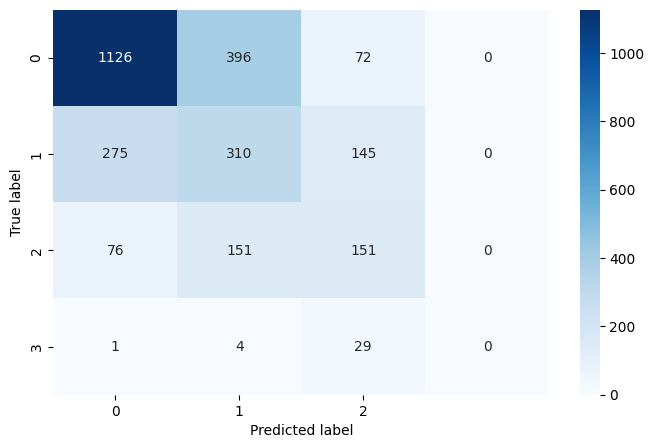

In [14]:
cm = confusion_matrix(oof_preds_006["sii"], oof_preds_006["preds"])
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", 
    xticklabels=oof_preds_006["preds"].unique(), 
    yticklabels=oof_preds_006["sii"].unique()
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Feature importance

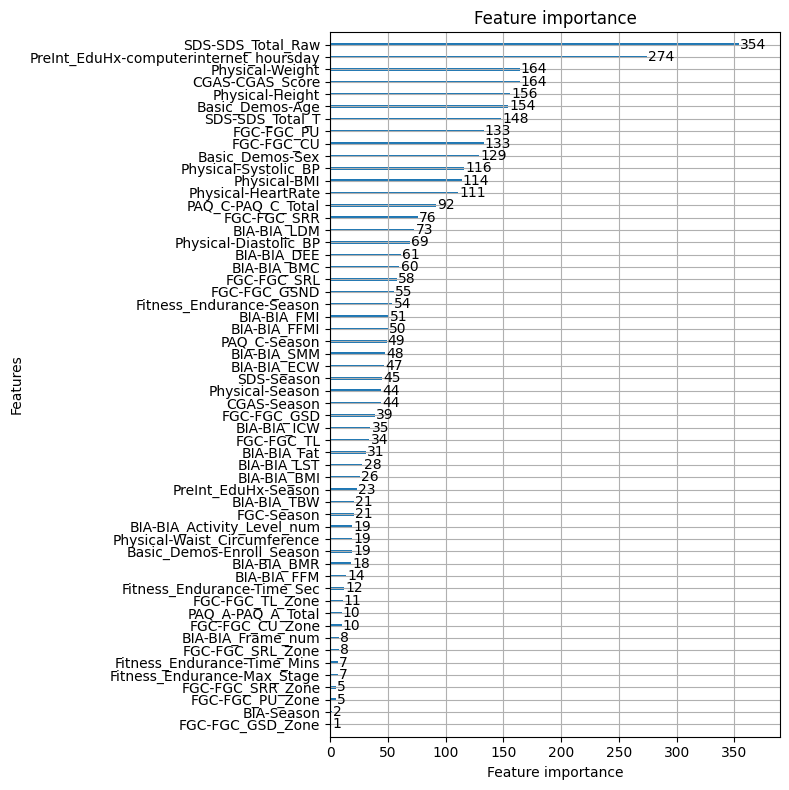

In [19]:
lgb.plot_importance(booster, figsize=(8, 8))
plt.tight_layout()
plt.show()

### Learning curve

In [15]:
eval_result = pl.read_csv("/kaggle/temp/exp006_hyperparameter_tuning/log_metric.csv")

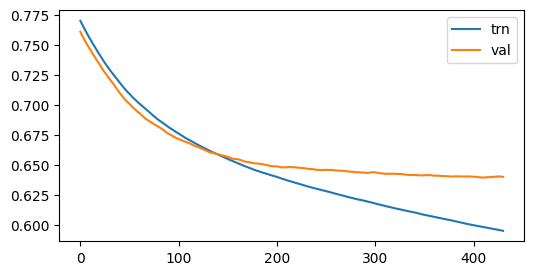

In [18]:
plt.figure(figsize=(6, 3))
plt.plot(eval_result["trn_rmse"].to_numpy(), label="trn")
plt.plot(eval_result["val_rmse"].to_numpy(), label="val")
# fig, axes = plt.subplots(1, 2, figsize=(12, 3))
# axes[0].plot(eval_result["trn_rmse"].to_numpy(), label="trn")
# axes[0].plot(eval_result["val_rmse"].to_numpy(), label="val")
# axes[0].set_xlabel("epoch")
# axes[0].set_ylabel("rmse")
# axes[1].plot(eval_result["trn_qwk"].to_numpy(), label="trn")
# axes[1].plot(eval_result["val_qwk"].to_numpy(), label="val")
# axes[1].set_xlabel("epoch")
# axes[1].set_ylabel("quadratic_weighted_kappa")
plt.legend()
plt.show()